# 1-4,时间序列数据建模流程范例

2020年发生的新冠肺炎疫情灾难给各国人民的生活造成了诸多方面的影响。

有的同学是收入上的，有的同学是感情上的，有的同学是心理上的，还有的同学是体重上的。

本文基于中国2020年3月之前的疫情数据，建立时间序列RNN模型，对中国的新冠肺炎疫情结束时间进行预测。

![](./data/疫情前后对比.png)

In [1]:
import torch 
print("torch.__version__ = ", torch.__version__)



torch.__version__ =  2.0.1


<br>

<font color="red">
 
公众号 **算法美食屋** 回复关键词：**pytorch**， 获取本项目源码和所用数据集百度云盘下载链接。
    
</font> 


In [ ]:
import os

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 


## 一，准备数据

本文的数据集取自tushare，获取该数据集的方法参考了以下文章。

《https://zhuanlan.zhihu.com/p/109556102》

![](./data/1-4-新增人数.png)


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt


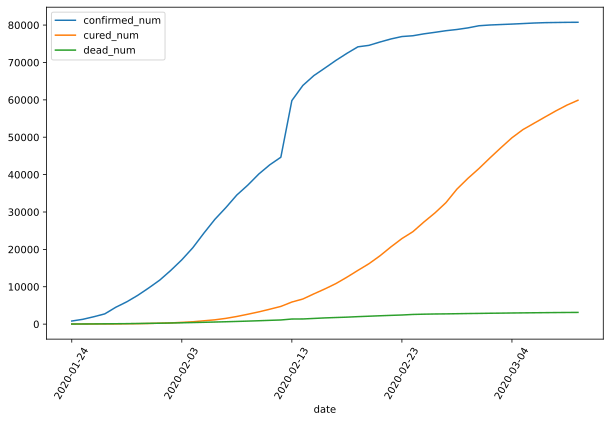

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

df = pd.read_csv("./eat_pytorch_datasets/covid-19.csv",sep = "\t")
df.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60);


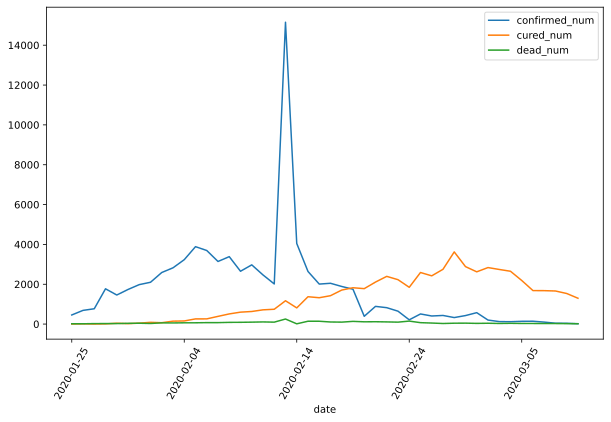

In [4]:
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index("date")

dfdiff.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop("date",axis = 1).astype("float32")


In [5]:
dfdiff.head()

,confirmed_num,cured_num,dead_num
0,457.0,4.0,16.0
1,688.0,11.0,15.0
2,769.0,2.0,24.0
3,1771.0,9.0,26.0
4,1459.0,43.0,26.0


下面我们通过继承torch.utils.data.Dataset实现自定义时间序列数据集。

torch.utils.data.Dataset是一个抽象类，用户想要加载自定义的数据只需要继承这个类，并且覆写其中的两个方法即可：

* `__len__`:实现len(dataset)返回整个数据集的大小。
* `__getitem__`:用来获取一些索引的数据，使`dataset[i]`返回数据集中第i个样本。

不覆写这两个方法会直接返回错误。


In [6]:
import torch 
from torch import nn 
from torch.utils.data import Dataset,DataLoader,TensorDataset


#用某日前8天窗口数据作为输入预测该日数据
WINDOW_SIZE = 8

class Covid19Dataset(Dataset):
        
    def __len__(self):
        return len(dfdiff) - WINDOW_SIZE
    
    def __getitem__(self,i):
        x = dfdiff.loc[i:i+WINDOW_SIZE-1,:]
        feature = torch.tensor(x.values)
        y = dfdiff.loc[i+WINDOW_SIZE,:]
        label = torch.tensor(y.values)
        return (feature,label)
    
ds_train = Covid19Dataset()

#数据较小，可以将全部训练数据放入到一个batch中，提升性能
dl_train = DataLoader(ds_train,batch_size = 38)

for features,labels in dl_train:
    break 
    
#dl_train同时作为验证集
dl_val = dl_train


## 二，定义模型

使用Pytorch通常有三种方式构建模型：使用nn.Sequential按层顺序构建模型，继承nn.Module基类构建自定义模型，继承nn.Module基类构建模型并辅助应用模型容器进行封装。

此处选择第二种方式构建模型。



In [7]:
import torch
from torch import nn 
import importlib 
import torchkeras 

torch.random.seed()

class Block(nn.Module):
    def __init__(self):
        super(Block,self).__init__()
    
    def forward(self,x,x_input):
        x_out = torch.max((1+x)*x_input[:,-1,:],torch.tensor(0.0))
        return x_out
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3层lstm
        self.lstm = nn.LSTM(input_size = 3,hidden_size = 3,num_layers = 5,batch_first = True)
        self.linear = nn.Linear(3,3)
        self.block = Block()
        
    def forward(self,x_input):
        x = self.lstm(x_input)[0][:,-1,:]
        x = self.linear(x)
        y = self.block(x,x_input)
        return y
        
net = Net()
print(net)



Net(
  (lstm): LSTM(3, 3, num_layers=5, batch_first=True)
  (linear): Linear(in_features=3, out_features=3, bias=True)
  (block): Block()
)


```
Net(
  (lstm): LSTM(3, 3, num_layers=5, batch_first=True)
  (linear): Linear(in_features=3, out_features=3, bias=True)
  (block): Block()
)
```

In [9]:
from torchkeras import summary
summary(net,input_data=features);

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
LSTM-1                                    [-1, 8, 3]                  480
Linear-2                                     [-1, 3]                   12
Block-3                                      [-1, 3]                    0
Total params: 492
Trainable params: 492
Non-trainable params: 0
--------------------------------------------------------------------------
Input size (MB): 0.000069
Forward/backward pass size (MB): 0.000229
Params size (MB): 0.001877
Estimated Total Size (MB): 0.002174
--------------------------------------------------------------------------


### 三，训练模型

训练Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。

有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。

此处我们通过引入torchkeras库中的KerasModel工具来训练模型，无需编写自定义循环。

torchkeras详情:  https://github.com/lyhue1991/torchkeras 

注：循环神经网络调试较为困难，需要设置多个不同的学习率多次尝试，以取得较好的效果。



In [13]:
from torchmetrics.regression import MeanAbsolutePercentageError

def mspe(y_pred,y_true):
    err_percent = (y_true - y_pred)**2/(torch.max(y_true**2,torch.tensor(1e-7)))
    return torch.mean(err_percent)

net = Net() 
loss_fn = mspe
metric_dict = {"mape":MeanAbsolutePercentageError()}

optimizer = torch.optim.Adam(net.parameters(), lr=0.03)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.0001)

In [14]:
from torchkeras import KerasModel 
model = KerasModel(net,
       loss_fn = loss_fn,
       metrics_dict= metric_dict,
       optimizer = optimizer,
       lr_scheduler = lr_scheduler) 


<<<<<< 🐌 cpu is used >>>>>>


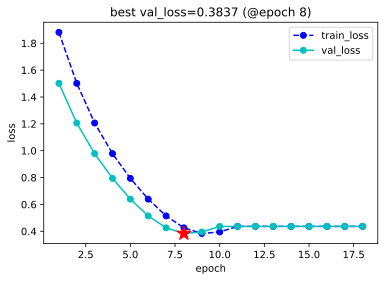

<<<<<< val_loss without improvement in 10 epoch,early stopping >>>>>> 



In [15]:
dfhistory = model.fit(train_data=dl_train,
            val_data=dl_val,
            epochs=100,
            ckpt_path='checkpoint',
            patience=10,
            monitor='val_loss',
            mode='min',
            callbacks=None,
            plot=True,
            cpu=True
            )


### 四，评估模型

评估模型一般要设置验证集或者测试集，由于此例数据较少，我们仅仅可视化损失函数在训练集上的迭代情况。

In [18]:
model.evaluate(dl_val)


100%|█████████████████████████████████| 1/1 [00:00<00:00, 63.91it/s, val_loss=0.384, val_mape=0.505]


{'val_loss': 0.38373321294784546, 'val_mape': 0.5048269033432007}

### 五，使用模型

此处我们使用模型预测疫情结束时间，即 新增确诊病例为0 的时间。

In [19]:
#使用dfresult记录现有数据以及此后预测的疫情数据
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


In [20]:
#预测此后1000天的新增走势,将其结果添加到dfresult中
for i in range(1000):
    arr_input = torch.unsqueeze(torch.from_numpy(dfresult.values[-38:,:]),axis=0)
    arr_predict = model.forward(arr_input)

    dfpredict = pd.DataFrame(torch.floor(arr_predict).data.numpy(),
                columns = dfresult.columns)
    dfresult = pd.concat([dfresult,dfpredict],ignore_index=True)

In [21]:
dfresult.query("confirmed_num==0").head()

# 第50天开始新增确诊降为0，第45天对应3月10日，也就是5天后，即预计3月15日新增确诊降为0
# 注：该预测偏乐观


,confirmed_num,cured_num,dead_num
50,0.0,999.0,0.0
51,0.0,948.0,0.0
52,0.0,900.0,0.0
53,0.0,854.0,0.0
54,0.0,810.0,0.0


In [22]:
dfresult.query("cured_num==0").head()
# 第137天开始新增治愈降为0，第45天对应3月10日，也就是大概3个月后，即6月12日左右全部治愈。
# 注: 该预测偏悲观，并且存在问题，如果将每天新增治愈人数加起来，将超过累计确诊人数。

,confirmed_num,cured_num,dead_num
137,0.0,0.0,0.0
138,0.0,0.0,0.0
139,0.0,0.0,0.0
140,0.0,0.0,0.0
141,0.0,0.0,0.0


### 六，保存模型

模型权重保存在了model.ckpt_path路径。

In [23]:
print(model.ckpt_path)

checkpoint


In [24]:
model.load_ckpt('checkpoint') #可以加载权重

**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)